---
title: Voice Emotion Classification
author: Catie Baxter and Otis Milliken 
date: '2024-04-07'
description: "Final Project for CS0451"
format: html
---

Here is a link to the [dataset](https://zenodo.org/records/1188976#.XrC7a5NKjOR) with used.

The files in our dataset were named using a specific naming structure by the original authors. Each file has a unique filename that act as identifiers for the characteristics of the audio file.

There are 7 digits, divided by dashes (e.g. "02-01-06-01-02-01-12.mp4"). 

The first digit reflects the **modality**:
    01 - full-AV
    02 - video only
    03 - audio-only

The second digit is the vocal channel. We are only investigating the speech files so they will all be 01.

The third digit is the **emotion** which will be our target variable.
    01 - neutral
    02 - calm
    03 - happy
    04 - sad
    05 - angry
    06 - fearful
    07 - disgust
    08 - surprised

The fourth digit reflects the emotional intensity, which is 01 for normal and 02 for strong.

The fifth digit reflects the **statement** in the file:
    01 - "Kids are talking by the door"
    02 - "Dogs are sitting by the door"

The sixth digit indicates the repetition number of the study: 01 or 02.

Finally the seventh digit is the actor that spoke in the recording, labelled 01 to 24. Odd numbers are male and even numbers are female. 


In [40]:
import os
import pandas as pd
import librosa
# assign directory

directory = "data"

dictionary = {
    'Filepath': [],
    'Modality': [],
    'Vocal_channel': [],
    'Emotion':[],
    'Emotional_intensity':[],
    'Statement':[],
    'Repetition':[],
    'Actor':[],
    'Sample':[],
    'Sample_rate': [],
    'Sex':[],
    'Mel_sgram': []
}

def parse_filename(file):
    filename = file[5:-4]
    digits = filename.split("-")
    dictionary['Modality'].append(digits[0])
    dictionary['Vocal_channel'].append(digits[1])
    dictionary['Emotion'].append(int(digits[2]))
    dictionary['Emotional_intensity'].append(digits[3])
    dictionary['Statement'].append(digits[4])
    dictionary['Repetition'].append(digits[5])
    dictionary['Actor'].append(digits[6])
    dictionary['Sex'].append('Female' if (int(digits[6]) % 2) == 0 else 'Male') # odd numbers are male (1), even numbers female (0)
    return 

def create_sgram(sample, sr):
    sgram = librosa.stft(sample)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=0)
    return mel_sgram

def getting_files(directory):
    for filename in os.listdir(directory):
        file = os.path.join(directory, filename) 
        if os.path.isfile(file):
            dictionary['Filepath'].append(file)
            samples, samplerate = librosa.load(file)
            dictionary['Sample'].append(samples)
            dictionary['Sample_rate'].append(samplerate)
            dictionary['Mel_sgram'].append(create_sgram(samples, samplerate))
            parse_filename(file)


getting_files(directory)

df_y = pd.DataFrame(dictionary["Emotion"])
df_X = pd.DataFrame(dictionary).drop(columns=["Emotion"])

[[21.239113 21.239113 21.239113 ... 21.239113 21.239113 21.53032 ]
 [21.239113 21.239113 21.239113 ... 21.239113 21.239113 22.112213]
 [21.239113 21.239113 21.239113 ... 21.239113 21.239113 21.239113]
 ...
 [21.239113 21.239113 21.239113 ... 21.239113 21.239113 21.239113]
 [21.239113 21.239113 21.239113 ... 21.239113 21.239113 21.239113]
 [21.239113 21.239113 21.239113 ... 21.239113 21.239113 21.239113]]


In [101]:
df_y.values

array([[6],
       [5],
       [8],
       ...,
       [2],
       [8],
       [1]])

In [121]:
import torch
max_length = 0
for i in range(len(df_X["Mel_sgram"])):
    max_length = max(df_X["Mel_sgram"][i].shape[1], max_length)

def padding_mel(df):
    X = torch.empty(len(df["Mel_sgram"]), df["Mel_sgram"][0].shape[0], max_length)
    for iter, seq in enumerate(df["Mel_sgram"]):
        length = seq.shape[1]
        seq = torch.tensor(seq)
        if length < max_length:
            pad = torch.zeros(128, max_length - length)
            X[iter] = torch.cat((seq, pad), dim = 1)
        else:
            X[iter] = seq
        iter += 1
    return X
    
y = torch.tensor(df_y.values)

In [123]:
SAMPLE_RATE = df_X["Sample_rate"][0]

In [158]:
## Divide Data into Testing and Training
import numpy as np
from numpy import random

# Split the data so that 50% is used for training, and 50% is used for testing
def split_data(X, y):
    n, p = X.shape[0], X.shape[1] 
    random_test_index = torch.randperm(X.size(0))[:int(n/3)]
    y_train = y[~random_test_index.bool()]
    y_train = torch.where(random_test_index)
    X_train = X[~random_test_index.bool()]
    y_test = y[random_test_index]
    X_test = X[random_test_index]
    return y_train, X_train, y_test, X_test

y_train, X_train, y_test, X_test = split_data(X, y)

print(f'y_train: {y_train.shape}, X_train: {X_train.shape}, y_test: {y_test.shape}, X_test: {X_test.shape}')


IndexError: The shape of the mask [480] at index 0 does not match the shape of the indexed tensor [1440, 1] at index 0

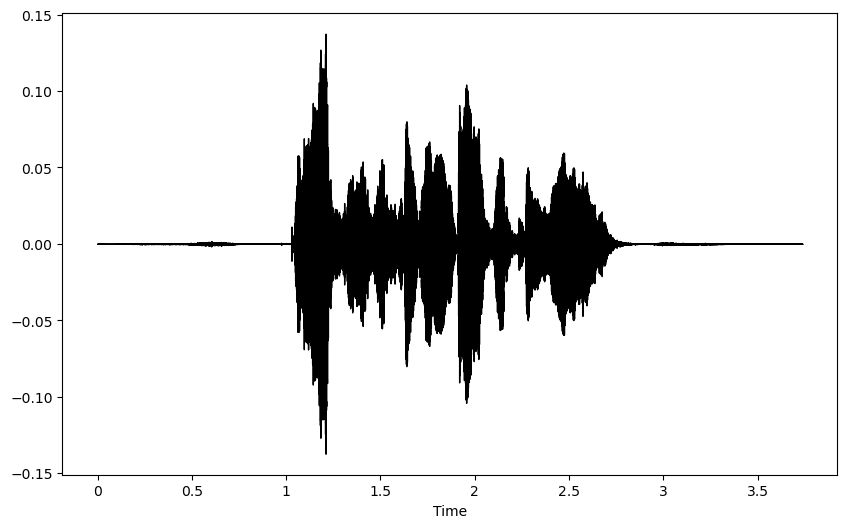

In [124]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
librosa.display.waveshow(df_X["Sample"][0], sr=df_X["Sample_rate"][0], color="black")

## Creating Mel Spectogram

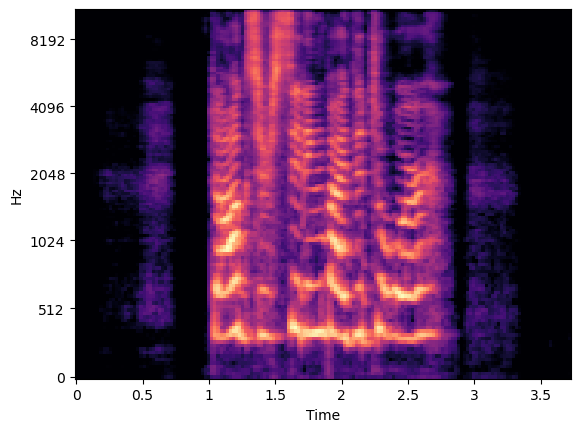

In [127]:
librosa.display.specshow(df_X["Mel_sgram"][0], sr=df_X["Sample_rate"][0], x_axis='time', y_axis='mel')

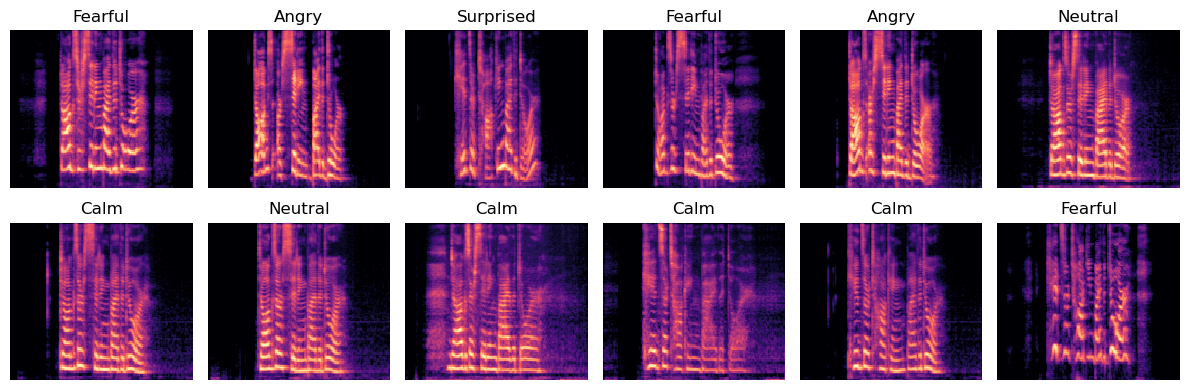

In [141]:
from matplotlib import pyplot as plt
EMOTIONS = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

def show_images(X, y, rows, cols, channel = 0):
    fig, axarr = plt.subplots(rows, cols, figsize = (2*cols, 2*rows))
    for i, ax in enumerate(axarr.ravel()):
        librosa.display.specshow(X[i], sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=ax)
        ax.set(title = f"{EMOTIONS[y[i]-1]}")
        ax.axis("off")
    plt.tight_layout()

show_images(df_X["Mel_sgram"], y, 2, 6)